In [19]:
#PART 1: REGRESSION INTRODUCTION
#!pip install quandl

In [20]:
import sklearn
#import quandl
import pandas as pd

#df= quandl.get('WIKI/GOOGL')

#print(df.head())

In [21]:
'''from google.colab import files

df.to_csv('df.csv')
files.download('df.csv')'''

"from google.colab import files\n\ndf.to_csv('df.csv')\nfiles.download('df.csv')"

In [22]:
!pip install PyDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
df_path='/content/drive/My Drive/Datasets/Google stock prices/df.csv' 
df=pd.read_csv(df_path,header=0, index_col='Date',parse_dates=True)
#print(df.columns)

In [24]:
#Select columns that are needed
df= df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close','Adj. Volume']]

#Add a column with the values of high low percentage
df['HL_PCT']= (df['Adj. High']- df['Adj. Close'])/ df['Adj. Close'] * 100.0

#Calculate percentage change
df['PCT_change']= (df['Adj. Close']- df['Adj. Open'])/ df['Adj. Open'] * 100.0

#Re-define necessary columns
df= df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]

#df.head()



In [25]:
#PART 2: FEATURES AND LABELS
forecast_col= 'Adj. Close' #The name of the column that we will be forecasting  
df.fillna(-99999, inplace=True) #Fill all the places with missing values with -99999. inplace=True is used to modify the values in the origial dataframe and not return a copy 

import math
forecast_out= int(math.ceil(0.01*len(df))) #Predict value 1% of total days forward

df['label']= df[forecast_col].shift(-forecast_out)  #shifting rows of the column to be forecasted upwards

df.dropna(inplace=True)

print(df.head())
print(df.tail())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  3.712563    0.324968   44659000.0  69.078238
2004-08-20   54.322689  0.710922    7.227007   22834300.0  67.839414
2004-08-23   54.869377  3.729433   -1.227880   18256100.0  68.912727
2004-08-24   52.597363  6.417469   -5.726357   15247300.0  70.668146
2004-08-25   53.164113  1.886792    1.183658    9188600.0  71.219849
            Adj. Close    HL_PCT  PCT_change  Adj. Volume    label
Date                                                              
2018-01-30     1177.37  0.896914   -0.029718    1792602.0  1094.00
2018-01-31     1182.22  0.346805   -0.134312    1643877.0  1053.15
2018-02-01     1181.59  0.495942    0.476195    2774967.0  1026.55
2018-02-02     1119.20  1.081129   -0.729098    5798880.0  1054.09
2018-02-05     1068.76  4.325574   -2.893850    3742469.0  1006.94


In [26]:
#PART 3: REGRESSION TRAINING AND TESTING
import numpy as np
from sklearn import preprocessing, svm #for scaling features and other metrics | separate data into train and test
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate


X = np.array(df.drop(['label'],1)) #store features

#Part 4 change
X = preprocessing.scale(X) #Normalising values between -1 and 1
X_lately=X[-forecast_out:]
X=X[:-forecast_out]


df.dropna(inplace=True)

y = np.array(df['label']) #store label
y_lately=y[-forecast_out:]
y=y[:-forecast_out]


In [27]:
print(len(X), len(y)) #check to see whether features and labels are of same length 

3354 3354


In [28]:
import pickle
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2) #shuffle and split the data into train and test sets

#clf= LinearRegression()
#clf.fit(X_train, y_train) #synonymous to training

#with open('linearregression.pickle','wb') as f:
  #pickle.dump(clf,f)


pickle_path='/content/drive/My Drive/Datasets/Google stock prices/linearregression.pickle' #Part 5: Pickling
pickle_in= open(pickle_path,'rb')
clf= pickle.load(pickle_in)
accuracy= clf.score(X_test, y_test) #synonymous to testing

#print(accuracy)

In [29]:
#Using Support Vector Machine to switch algorithms
#We replace it with Support Vector Regression

#clf= svm.SVR()
'''clf= svm.SVR(kernel='poly')
clf.fit(X_train, y_train) #synonymous to training
accuracy= clf.score(X_test, y_test) #synonymous to testing'''

#print(accuracy)

"clf= svm.SVR(kernel='poly')\nclf.fit(X_train, y_train) #synonymous to training\naccuracy= clf.score(X_test, y_test) #synonymous to testing"

In [30]:
#PART 4: FORECASTING AND PREDICTING
forecast_set = clf.predict(X_lately) 

print(forecast_set, accuracy, forecast_out)

[1081.57730083 1096.38628232 1110.27101419 1105.12697425 1098.70509604
 1095.95892395 1094.25801599 1091.25355289 1085.10168049 1080.6872657
 1078.30203081 1097.37053725 1115.97211008 1120.95360403 1135.81771482
 1139.90109663 1138.79288401 1136.03692672 1137.94031319 1156.01488791
 1155.79597654 1165.71547167 1162.38212288 1170.03387393 1190.05819864
 1202.9779635  1197.58471356 1209.30597101 1215.04158668 1212.96491119
 1203.66582301 1209.35180808 1207.91755032 1143.71661483 1090.24621194] 0.9759585179883861 35


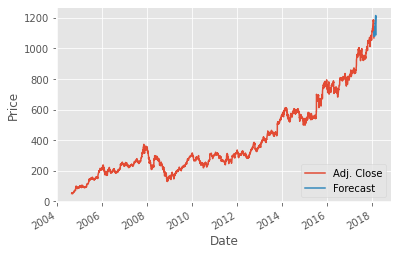

In [31]:
import datetime 
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

df['Forecast'] = np.nan
last_date = df.iloc[-1].name


last_unix = last_date.timestamp()

one_day = 86400
next_unix = last_unix + one_day 

for i in forecast_set:
  next_date=datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_day
  df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
#plt.rcParams["figure.figsize"] = [15,9]

plt.show()

In [32]:
#PART 5: PICKLING AND SCALING
#Pickle file stored after training, see above


